In [ ]:
!pip install malaya_speech
!pip install spectralcluster
!pip install pydub
import pandas as pd
import os
import json
from google.colab import files
import librosa as librosa
import librosa.display
import IPython.display as ipd
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt
from spectralcluster import SpectralClusterer
from pydub import AudioSegment
from pydub.silence import split_on_silence
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 
     |████████████████████████████████| 235 kB 55.9 MB/s 
     |████████████████████████████████| 5.5 MB 56.6 MB/s 
     |████████████████████████████████| 182 kB 54.9 MB/s 
     |████████████████████████████████| 41 kB 202 kB/s 
     |████████████████████████████████| 7.6 MB 19.9 MB/s 
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=39121228919aee578ef031ef63f9c67c923a7ea1062f0f0fb455616a32e3ca87
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995dbf11db6cede602e7ef
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=54816e914c70bd514ea898745ca7960de0d87a757534bf6e23565aa676359ed8
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Suc

/usr/local/lib/python3.7/dist-packages/malaya_boilerplate/frozen_graph.py:36: UserWarning: Cannot import beam_search_ops from Tensorflow Addons, ['malaya.jawi_rumi.deep_model', 'malaya.phoneme.deep_model', 'malaya.rumi_jawi.deep_model', 'malaya.stem.deep_model'] will not available to use, make sure Tensorflow Addons version >= 0.12.0
  f'Cannot import beam_search_ops from Tensorflow Addons, {USED_TREE} will not available to use, make sure Tensorflow Addons version >= 0.12.0'
/usr/local/lib/python3.7/dist-packages/malaya_boilerplate/frozen_graph.py:39: UserWarning: check compatible Tensorflow version with Tensorflow Addons at https://github.com/tensorflow/addons/releases
  'check compatible Tensorflow version with Tensorflow Addons at https://github.com/tensorflow/addons/releases')


In [ ]:
caller_audio = files.upload()

Saving caller.zip to caller.zip


In [ ]:
agent_audio = files.upload()

Saving agent.zip to agent.zip


In [ ]:
transcripts = files.upload()

Saving transcripts.zip to transcripts.zip


In [ ]:
!unzip -q caller.zip

In [ ]:
!unzip -q agent.zip

In [ ]:
!unzip -q transcripts.zip

In [ ]:
# Average word duration per block
def calc_word_dur(lst):
  sum = 0
  for i in range(len(lst)):
    sum += lst[i]
  return sum/len(lst)

# Averages by speaker -> returns average neutral, negative, positive emotions and average speech duration and average of averages word duration of the entire record.
def calc_data(data, speaker):
  counter = 0
  neu = 0
  neg = 0
  pos = 0
  total_dur = 0
  word_dur = 0
  sentence_len = 0
  for i in range(len(data)):
    if(data[i]['speaker_role'] == speaker):
      counter += 1
      neu += float(data[i]['emotion']['neutral'])
      neg += float(data[i]['emotion']['negative'])
      pos += float(data[i]['emotion']['positive'])
      total_dur += int(data[i]['duration_ms'])
      word_dur += int(calc_word_dur(data[i]['word_durations_ms']))
      sentence_len += int(len(data[i]['transcript'].split()))

  neu /= counter
  neg /= counter
  pos /= counter
  total_dur /= counter
  word_dur /= counter
  sentence_len /= counter


  return [neu, neg, pos, total_dur, word_dur, sentence_len]

In [ ]:
def makeTenSecondsAudio(filename):
  #Load audio
  # y, sr = malaya_speech.load(filename)
  y, sr = librosa.load(filename)

  #Cuts silence from the beggining and the end of the call
  y_trim = librosa.effects.trim(y, top_db=20)[0]

  #Cuts dead audio moments
  y_int = malaya_speech.astype.float_to_int(y_trim)
  audio = AudioSegment(
      y_int.tobytes(),
      frame_rate = sr,
      sample_width = y_int.dtype.itemsize,
      channels = 1
  )
  audio_chunks = split_on_silence(
      audio,
      min_silence_len = 200,
      silence_thresh = -30,
      keep_silence = 100,
  )
  
  #Sums all active audio parts and creates a united audio file
  final_y = sum(audio_chunks)
  final_y = np.array(final_y.get_array_of_samples())
  final_y = malaya_speech.astype.int_to_float(final_y)
  
  #If longer then 10 seconds, shortens to 10 ; otherwise remainds the same
  final_y = final_y[:sr*10]

  return final_y, sr

In [ ]:
def amplitude_envelope(signal, frame_size, hop_length):
  amp_env = []

  # calculate AE for each frame
  for i in range(0, len(signal), hop_length):
    current_amp_env = max(signal[i:i+frame_size])
    amp_env.append(current_amp_env)
  
  ae_array = np.array(amp_env)

  dictionary = {}
  dictionary['average'] = np.average(ae_array)
  dictionary['max'] = np.max(ae_array)
  dictionary['min'] = np.min(ae_array)
  dictionary['std'] = np.std(ae_array)
  dictionary['median'] = np.median(ae_array)
  
  return dictionary

In [ ]:
def rms(signal, frame_size, hop_length):
  rms = []

  for i in range(0, len(signal), hop_length):
    current_frame = np.sqrt(np.sum(signal[i:i+frame_size]**2)/frame_size)
    rms.append(current_frame)
  
  rms = np.array(rms)

  dictionary = {}
  dictionary['average'] = np.average(rms)
  dictionary['max'] = np.max(rms)
  dictionary['min'] = np.min(rms)
  dictionary['std'] = np.std(rms)
  dictionary['median'] = np.median(rms)
  
  return dictionary

In [ ]:
def zcr(signal, frame_size, hop_length):
  zcr_signal = librosa.feature.zero_crossing_rate(signal, frame_length=frame_size, hop_length=hop_length)[0]

  dictionary = {}
  dictionary['average'] = np.average(zcr_signal)
  dictionary['max'] = np.max(zcr_signal)
  dictionary['min'] = np.min(zcr_signal)
  dictionary['std'] = np.std(zcr_signal)
  dictionary['median'] = np.median(zcr_signal)

  return dictionary

In [ ]:
def log_mel_spectrogram_data(signal,sr , n_fft, hop_length):
  #Create MelSpectrogram
  mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, win_length=n_fft) ##, n_mels=mel_bins)

  #Create LogMelSpectrogram out of the MelSpectrogram
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

  dictionary = {}
  dictionary['average'] = np.average(log_mel_spectrogram)
  dictionary['max'] = np.max(log_mel_spectrogram)
  dictionary['min'] = np.min(log_mel_spectrogram)
  dictionary['std'] = np.std(log_mel_spectrogram)
  dictionary['median'] = np.median(log_mel_spectrogram)

  return dictionary

In [ ]:
def mfcc(signal, n_mfcc, sr):
  mfcc = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr)

  dictionary = {}
  dictionary['average'] = np.average(mfcc)
  dictionary['max'] = np.max(mfcc)
  dictionary['min'] = np.min(mfcc)
  dictionary['std'] = np.std(mfcc)
  dictionary['median'] = np.median(mfcc)

  return dictionary


In [ ]:
def createDataExample(signal, sr, frame_size, hop_length, n_fft, n_mfcc):
  amp_env = []
  rms = []

  # calculate AE for each frame
  for i in range(0, len(signal), hop_length):
    current_amp_env = max(signal[i:i+frame_size])
    amp_env.append(current_amp_env)
  
  ae_array = np.array(amp_env)

  # calculate RMS for each frame
  for i in range(0, len(signal), hop_length):
    current_frame = np.sqrt(np.sum(signal[i:i+frame_size]**2)/frame_size)
    rms.append(current_frame)
  
  rms = np.array(rms)

  # ZCR
  zcr_signal = librosa.feature.zero_crossing_rate(signal, frame_length=frame_size, hop_length=hop_length)[0]


  #Create MelSpectrogram
  mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, win_length=n_fft) ##, n_mels=mel_bins)

  #Create LogMelSpectrogram out of the MelSpectrogram
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

  # MFCC
  mfcc = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr)

  return [ae_array, rms, zcr_signal, mel_spectrogram, log_mel_spectrogram, mfcc]

In [ ]:
def createAudioDataRow(dict1, dict2, dict3, dict4, dict5):
  lst = np.append(list(dict1.values()), list(dict2.values()))
  lst = np.append(lst, list(dict3.values()))
  lst = np.append(lst, list(dict4.values()))
  lst = np.append(lst, list(dict5.values()))

  return lst
  

In [ ]:
# Audio feature extraction and return data
def audio_data_calc(path, name):
  filename = path + name
  signal, sr = makeTenSecondsAudio(filename)

  # properties
  FRAME_SIZE = 256
  N_FFT = 256
  HOP_LENGTH = 128
  N_MFCC=13

  # Time-Domain Features
  amp_env = amplitude_envelope(signal, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
  rms_signal = rms(signal, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
  zcr_signal = zcr(signal, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)

  # Time-Frequency-Domain Features
  log_mel = log_mel_spectrogram_data(signal, sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
  mfcc_ = mfcc(signal, n_mfcc=N_MFCC, sr=sr)

  features = createAudioDataRow(amp_env, rms_signal, zcr_signal, log_mel, mfcc_)
  

  return features

In [ ]:
def extraction(key):
  #Load json file (transcript)
  filename = str(key)
  with open(os.path.join('transcripts', filename), 'r') as f:
    data = json.load(f)

  # Extract transcript data
  agent_data = calc_data(data,'agent')
  caller_data = calc_data(data,'caller')
  
  #Change filename to .wav from .json
  filename = filename.split('.')
  filename = filename[0]
  filename = filename + '.wav'

  # Extract audio features data
  agent_audio_data = audio_data_calc('./agentaudio/', filename)
  caller_audio_data = audio_data_calc('./calleraudio/', filename)

  # Build a row of a single prediction of each type for each < json : (agent wav, caller wav) >
  agent_row = np.append(agent_data, agent_audio_data)
  caller_row = np.append(caller_data, caller_audio_data)

  # Y label
  # Assuming that the agent is the higher status in this dataset
  agent_row = np.append(agent_row, [1])
  caller_row = np.append(caller_row, [0])

  # Return the row into the dataframe
  return agent_row, caller_row

In [ ]:
def createDataset():
  # Properties
  completed_files = []
  id_counter = 0

  # Create Labels Row Here
  labels = ['ID','Filename', 'Neutral', 'Negative', 'Positive', 'Avg_Sentence_Duration', 'Avg_Word_Duration','Avg_Sentence_Length',
            'Amp_Env_Avg', 'Amp_Env_Max', 'Amp_Env_Min','Amp_Env_STD', 'Amp_Env_Median',
            'RMS_Avg', 'RMS_Max', 'RMS_Min','RMS_STD', 'RMS_Median',
            'ZCR_Avg', 'ZCR_Max', 'ZCR_Min','ZCR_STD', 'ZCR_Median',
            'Mel_Spec_Avg', 'Mel_Spec_Max', 'Mel_Spec_Min','Mel_Spec_STD', 'Mel_Spec_Median',
            'MFCC_Avg', 'MFCC_Max', 'MFCC_Min','MFCC_STD', 'MFCC_Median','Label']

  # Create empty data framehere
  mydataframe = pd.DataFrame(columns = labels)

  # Extract all data
  directory = 'transcripts'
  tempCounter = 0
  for filename in os.listdir(directory):
    if tempCounter < 20:
      if not filename in completed_files:
        print(f"{tempCounter} : {filename}")
        completed_files.append(filename)
        agent_features, caller_features = extraction(filename)

        agent_row = np.append([id_counter, filename.split(".")[0]], agent_features)
        id_counter += 1
        caller_row = np.append([id_counter, filename.split(".")[0]], caller_features)
        id_counter += 1
        # add rows to the dataframe
        mydataframe.loc[len(mydataframe.index)] = agent_row
        mydataframe.loc[len(mydataframe.index)] = caller_row
        tempCounter += 1
    else:
      break
  return mydataframe

In [ ]:
df = createDataset()

df

0 : 0afb6248e8dc45e1.json


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


1 : 0a9e9e9be6634e38.json
2 : 0a70acb6ef0c4e89.json
3 : 0b5d3de182a04159.json
4 : 0a37e848a9c04e0c.json
5 : 00f7dce6fc3849a2.json
6 : 00d676d7058c49bb.json
7 : 0ade4b6adcf941f0.json
8 : 0a6f57765f4641a2.json
9 : 0a76782d6ee84f73.json


,ID,Filename,Neutral,Negative,Positive,Avg_Sentence_Duration,Avg_Word_Duration,Avg_Sentence_Length,Amp_Env_Avg,Amp_Env_Max,...,Mel_Spec_Max,Mel_Spec_Min,Mel_Spec_STD,Mel_Spec_Median,MFCC_Avg,MFCC_Max,MFCC_Min,MFCC_STD,MFCC_Median,Label
0,0,0afb6248e8dc45e1,0.44591743250687915,0.15112886764109135,0.40295370171467465,2500.0,255.16666666666666,8.833333333333334,0.2241283506155014,1.0,...,0.0,-80.0,19.238985061645508,-80.0,-19.660741806030273,251.57476806640625,-496.2641296386719,93.537353515625,-12.467805862426758,1.0
1,1,0afb6248e8dc45e1,0.6852732084014199,0.12471251613037153,0.19001428444277157,1080.0,291.72727272727275,3.3636363636363638,0.4991843104362488,1.0,...,0.0,-80.0,23.2502384185791,-74.42948150634766,-6.847650527954102,252.59881591796875,-480.5696716308594,81.19667053222656,-4.733353137969971,0.0
2,2,0a9e9e9be6634e38,0.4058917959531148,0.0937224452694257,0.5003857687115669,2625.0,216.33333333333334,10.333333333333334,0.22980448603630066,0.8284249305725098,...,0.0,-80.0,19.532150268554688,-76.45066833496094,-13.92951488494873,228.16497802734375,-494.6324157714844,91.84942626953125,-6.60650634765625,1.0
3,3,0a9e9e9be6634e38,0.4455077573657036,0.17458721064031124,0.37990500777959824,1672.5,307.25,7.0,0.3399823009967804,0.9604785442352295,...,-9.5367431640625e-07,-80.0,22.512178421020508,-72.05623626708984,-17.208301544189453,257.7857666015625,-477.6948547363281,93.30905151367188,-14.910820007324219,0.0
4,4,0a70acb6ef0c4e89,0.45505349744449963,0.20465813018381596,0.34028834917328576,1579.090909090909,224.63636363636363,6.454545454545454,0.2626686692237854,1.0,...,0.0,-80.0,19.488161087036133,-80.0,-18.30181121826172,260.33465576171875,-496.9698486328125,91.9887924194336,-11.011817932128906,1.0
5,5,0a70acb6ef0c4e89,0.4907449513673782,0.138342360034585,0.37091268599033356,2391.0,352.9,6.5,0.17745479941368103,0.7104403972625732,...,0.0,-80.0,20.212987899780273,-77.75955963134766,-15.843815803527832,276.4184875488281,-546.7914428710938,102.25721740722656,-9.31869888305664,0.0
6,6,0b5d3de182a04159,0.46798994541168215,0.16611894471570848,0.36589111387729645,1659.0,273.3,7.2,0.11602089554071426,0.7992492318153381,...,-9.5367431640625e-07,-80.0,18.231882095336914,-80.0,-23.588491439819336,237.373779296875,-563.3294677734375,106.0425033569336,-8.010135650634766,1.0
7,7,0b5d3de182a04159,0.472460013628006,0.25428248606622217,0.2732575088739395,1362.0,211.0,5.2,0.23435458540916443,1.0,...,9.5367431640625e-07,-80.0,19.913049697875977,-80.0,-22.20892906188965,231.61447143554688,-494.3214416503906,94.02693939208984,-11.608409881591797,0.0
8,8,0a37e848a9c04e0c,0.43981294168366325,0.12880045030679968,0.4313866115278668,1683.3333333333333,287.22222222222223,6.333333333333333,0.1468966156244278,0.9353923201560974,...,0.0,-80.0,16.941478729248047,-80.0,-23.56827735900879,231.46804809570312,-536.65869140625,103.90218353271484,-7.416584014892578,1.0
9,9,0a37e848a9c04e0c,0.768220830294821,0.09256776712006992,0.13921141624450684,826.6666666666666,230.94444444444446,2.611111111111111,0.5330955386161804,0.9974974989891052,...,0.0,-80.0,22.978761672973633,-74.29151916503906,-7.8562517166137695,251.9679412841797,-478.06365966796875,80.76640319824219,-6.057006359100342,0.0


In [ ]:
def aePlot(signal, ae_signal, hop_length):
  frames = range(0, ae_signal.size)
  t = librosa.frames_to_time(frames, hop_length=hop_length)

  plt.figure(figsize=(15,10))
  librosa.display.waveshow(signal, max_points = 11025, x_axis = 'time', alpha=0.6)
  plt.plot(t, ae_signal, color="red")
  plt.title("Test")
  plt.ylim((-1,1))
  plt.show()

In [ ]:
def rmsPlot(signal, rms_signal, hop_length):
  frames = range(0, rms_signal.size)
  t = librosa.frames_to_time(frames, hop_length=hop_length)
  plt.figure(figsize=(15,10))
  librosa.display.waveshow(signal, max_points = 11025, x_axis = 'time', alpha=0.6)
  plt.plot(t, rms_signal, color="red")
  plt.title("Test")
  plt.ylim((-1,1))
  plt.show()

In [ ]:
def zcrPlot(signal, zcr_signal, hop_length):
  frames = range(0, zcr_signal.size)
  t = librosa.frames_to_time(frames, hop_length=hop_length)
  plt.figure(figsize=(15,10))
  librosa.display.waveshow(signal, max_points = 11025, x_axis = 'time', alpha=0.6)
  plt.plot(t, zcr_signal, color="red")
  plt.title("Test")
  plt.ylim((-1,1))
  plt.show()

In [ ]:
def melSpectrogramPlot(mel_spectrogram_signal,sr):
  plt.figure(figsize=(15,10))
  librosa.display.specshow(mel_spectrogram_signal, sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.2f dB')
  plt.tight_layout()
  plt.show()

In [ ]:
def logMelSpectrogramPlot(log_mel_spectrogram_signal, sr):
  plt.figure(figsize=(15,10))
  librosa.display.specshow(log_mel_spectrogram_signal, sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.2f dB')
  plt.title('Log Mel Spectrogram')
  plt.tight_layout()
  plt.show()

In [ ]:
def mfccPlot(mfcc_signal, sr):
  plt.figure(figsize=(15,10))
  librosa.display.specshow(mfcc_signal, x_axis="time", sr=sr)
  plt.colorbar(format="%+2.2f")
  plt.tight_layout()
  plt.show()

In [ ]:
ex_signal, ex_sr = makeTenSecondsAudio('./agentaudio/0a9e9e9be6634e38.wav')
FRAME_SIZE = 256
N_FFT = 256
HOP_LENGTH = 128
N_MFCC=13
examples = createDataExample(ex_signal, ex_sr, FRAME_SIZE, HOP_LENGTH, N_FFT, N_MFCC)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


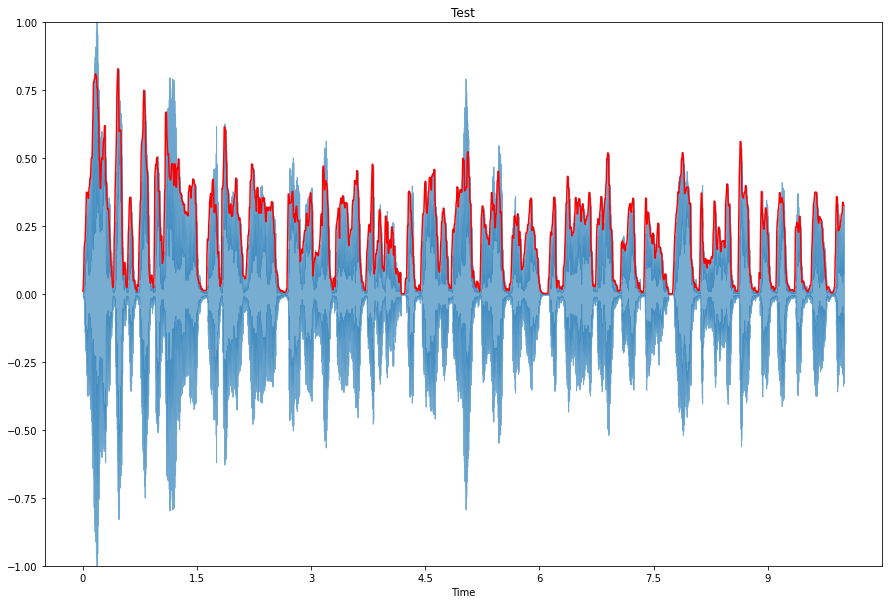

In [ ]:
aePlot(ex_signal, examples[0], HOP_LENGTH)

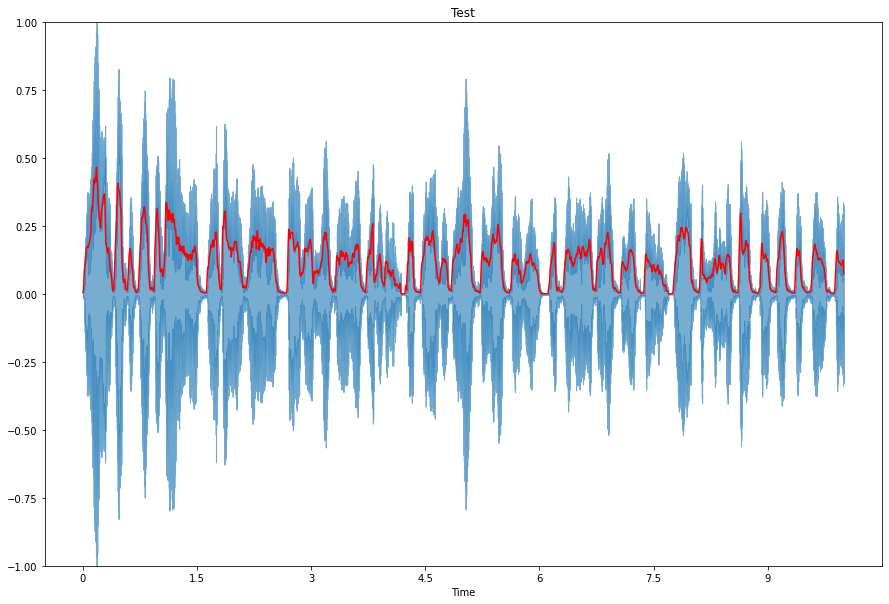

In [ ]:
rmsPlot(ex_signal, examples[1], HOP_LENGTH)

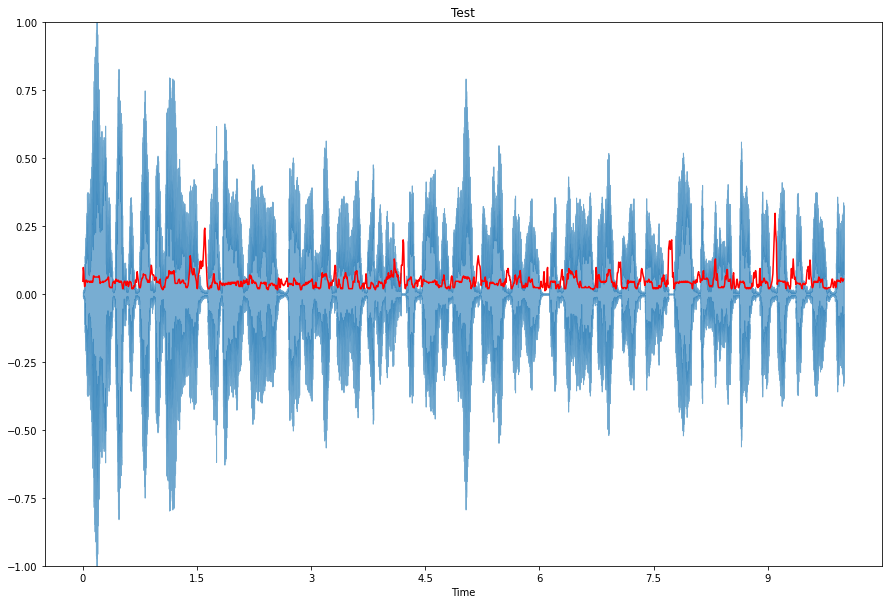

In [ ]:
zcrPlot(ex_signal, examples[2], HOP_LENGTH)

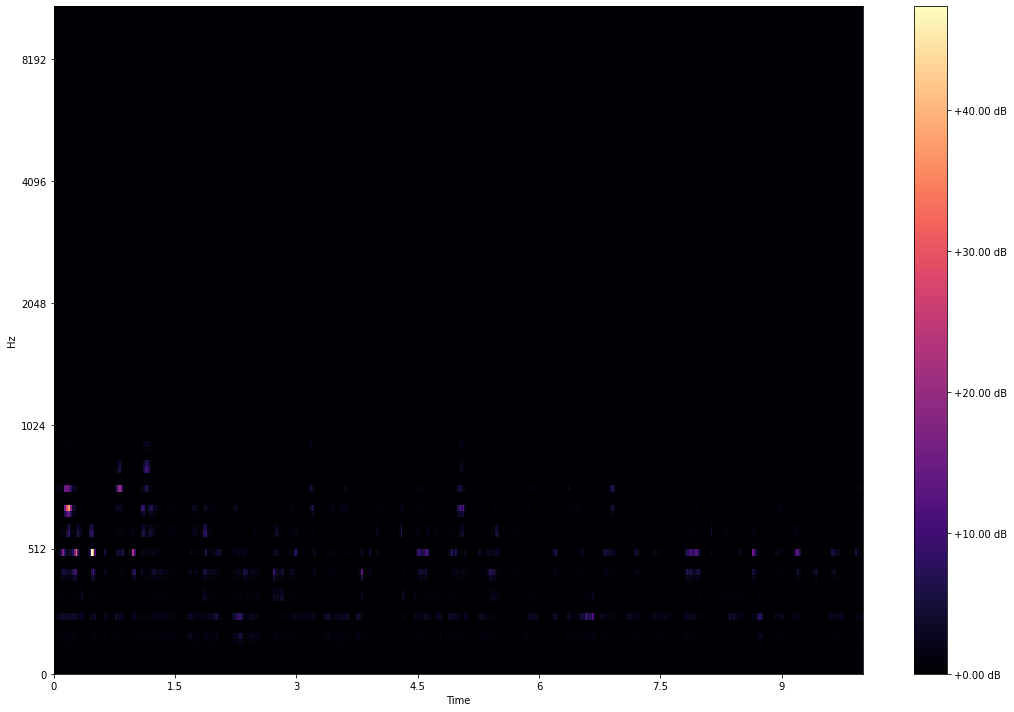

In [ ]:
melSpectrogramPlot(examples[3], ex_sr)

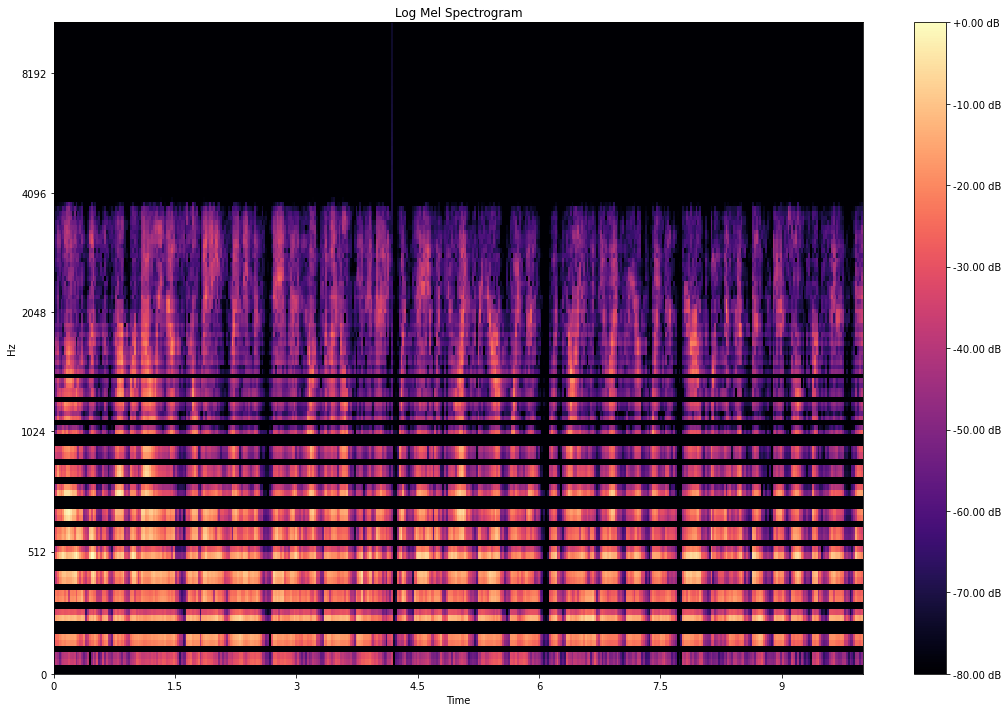

In [ ]:
logMelSpectrogramPlot(examples[4], ex_sr)

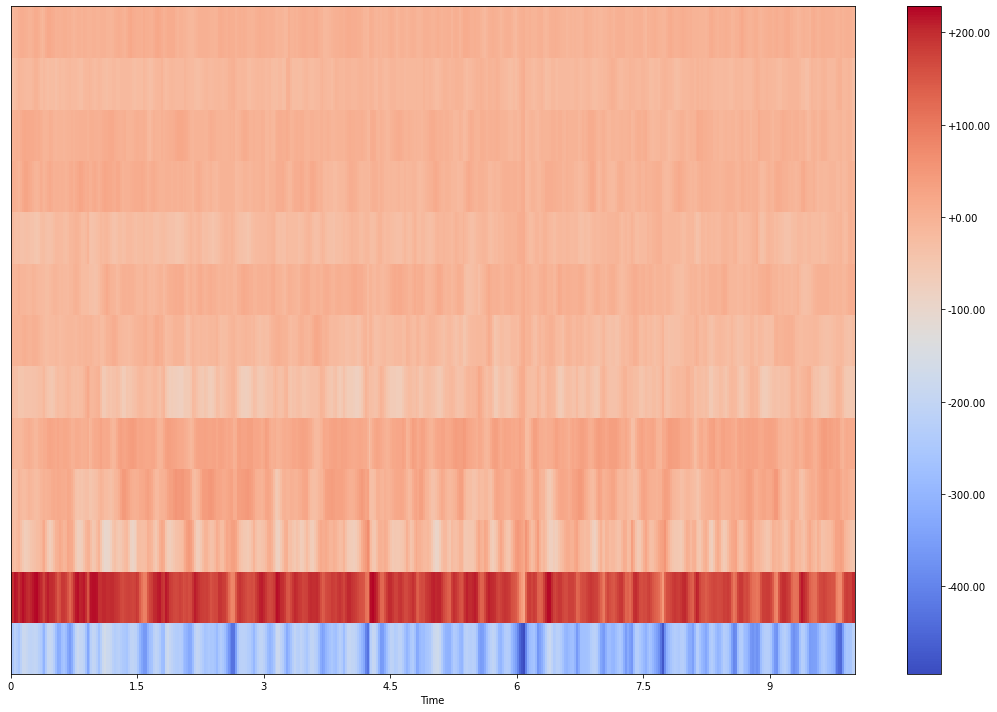

In [ ]:
mfccPlot(examples[5], ex_sr)

In [ ]:
!pip install catboost
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier #KNN
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score #score evaluation

from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df.head()

,ID,Filename,Neutral,Negative,Positive,Avg_Sentence_Duration,Avg_Word_Duration,Avg_Sentence_Length,Amp_Env_Avg,Amp_Env_Max,...,Mel_Spec_Max,Mel_Spec_Min,Mel_Spec_STD,Mel_Spec_Median,MFCC_Avg,MFCC_Max,MFCC_Min,MFCC_STD,MFCC_Median,Label
0,0,0afb6248e8dc45e1,0.44591743250687915,0.15112886764109135,0.40295370171467465,2500.0,255.16666666666666,8.833333333333334,0.2241283506155014,1.0,...,0.0,-80.0,19.238985061645508,-80.0,-19.660741806030273,251.57476806640625,-496.2641296386719,93.537353515625,-12.467805862426758,1.0
1,1,0afb6248e8dc45e1,0.6852732084014199,0.12471251613037153,0.19001428444277157,1080.0,291.72727272727275,3.3636363636363638,0.4991843104362488,1.0,...,0.0,-80.0,23.2502384185791,-74.42948150634766,-6.847650527954102,252.59881591796875,-480.5696716308594,81.19667053222656,-4.733353137969971,0.0
2,2,0a9e9e9be6634e38,0.4058917959531148,0.0937224452694257,0.5003857687115669,2625.0,216.33333333333334,10.333333333333334,0.22980448603630066,0.8284249305725098,...,0.0,-80.0,19.532150268554688,-76.45066833496094,-13.92951488494873,228.16497802734375,-494.6324157714844,91.84942626953125,-6.60650634765625,1.0
3,3,0a9e9e9be6634e38,0.4455077573657036,0.17458721064031124,0.37990500777959824,1672.5,307.25,7.0,0.3399823009967804,0.9604785442352295,...,-9.5367431640625e-07,-80.0,22.512178421020508,-72.05623626708984,-17.208301544189453,257.7857666015625,-477.6948547363281,93.30905151367188,-14.910820007324219,0.0
4,4,0a70acb6ef0c4e89,0.45505349744449963,0.20465813018381596,0.34028834917328576,1579.090909090909,224.63636363636363,6.454545454545454,0.2626686692237854,1.0,...,0.0,-80.0,19.488161087036133,-80.0,-18.30181121826172,260.33465576171875,-496.9698486328125,91.9887924194336,-11.011817932128906,1.0


In [ ]:
y_df = df.iloc[:,-1].values
x_df = df.drop(['ID',"Filename", "Label"], axis=1, inplace=False)

In [ ]:
#normelize the data using std
stdsc = StandardScaler()
x_std = stdsc.fit_transform(x_df)

In [ ]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(x_std, y_df, test_size = 0.20)
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(x_test.shape))
print('X_test:  '  + str(y_train.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (16, 31)
Y_train: (4, 31)
X_test:  (16,)
Y_test:  (4,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


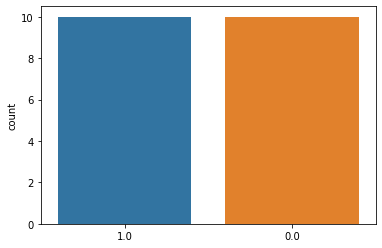

In [ ]:
#check for imballance data
countplit = sns.countplot(y_df)

In [ ]:
kfold = KFold(n_splits=5)
Means=[]
accuracy=[]
std=[]
classifiers=['Logistic Regression','KNN','CatBoost']
models=[LogisticRegression(),KNeighborsClassifier(n_neighbors=3),CatBoostClassifier(iterations=20,learning_rate=1,depth=2)]
for i in models:
    model = i
    cv_result = cross_val_score(model,x_train,y_train, cv = kfold,scoring = "accuracy")
    Means.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)

models_dataframe=pd.DataFrame({'CV Mean':Means,'Std':std},index=classifiers)  
models_dataframe 

0:	learn: 0.2688800	total: 541us	remaining: 10.3ms
1:	learn: 0.1435094	total: 1.06ms	remaining: 9.58ms
2:	learn: 0.0703555	total: 1.53ms	remaining: 8.65ms
3:	learn: 0.0532865	total: 1.99ms	remaining: 7.95ms
4:	learn: 0.0342073	total: 2.44ms	remaining: 7.32ms
5:	learn: 0.0234799	total: 3.16ms	remaining: 7.37ms
6:	learn: 0.0177401	total: 3.87ms	remaining: 7.18ms
7:	learn: 0.0145416	total: 4.6ms	remaining: 6.9ms
8:	learn: 0.0119591	total: 5.36ms	remaining: 6.55ms
9:	learn: 0.0104057	total: 6.08ms	remaining: 6.08ms
10:	learn: 0.0092583	total: 6.97ms	remaining: 5.7ms
11:	learn: 0.0083676	total: 7.71ms	remaining: 5.14ms
12:	learn: 0.0073788	total: 8.4ms	remaining: 4.52ms
13:	learn: 0.0067904	total: 9.14ms	remaining: 3.92ms
14:	learn: 0.0062996	total: 9.95ms	remaining: 3.31ms
15:	learn: 0.0056899	total: 10.7ms	remaining: 2.67ms
16:	learn: 0.0053394	total: 11.4ms	remaining: 2ms
17:	learn: 0.0050338	total: 12.1ms	remaining: 1.34ms
18:	learn: 0.0047127	total: 12.7ms	remaining: 670us
19:	learn: 0

,CV Mean,Std
Logistic Regression,0.766667,0.200000
KNN,0.633333,0.066667
CatBoost,0.866667,0.163299


In [ ]:
#for catboost model
Cat_parameters = {'depth'         : [2,3,4,5,6,7,8,9, 10],
                 'learning_rate' : [0.001,0.01,0.1,1],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}

CBC = CatBoostClassifier()
Grid_CBC_reg = GridSearchCV(estimator=CBC, param_grid = Cat_parameters, cv = 2, n_jobs=-1)
Grid_CBC_reg.fit(x_train,y_train)


print(" \nResults from Grid Searc, CAT BOOST:" )
print("\n The best score across ALL searched params:\n",Grid_CBC_reg.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC_reg.best_params_)

0:	learn: 0.3783636	total: 942us	remaining: 8.48ms
1:	learn: 0.2835742	total: 3.56ms	remaining: 14.2ms
2:	learn: 0.1837442	total: 5.15ms	remaining: 12ms
3:	learn: 0.0791417	total: 16.5ms	remaining: 24.7ms
4:	learn: 0.0477008	total: 18.5ms	remaining: 18.5ms
5:	learn: 0.0325618	total: 20.1ms	remaining: 13.4ms
6:	learn: 0.0243487	total: 21.8ms	remaining: 9.35ms
7:	learn: 0.0196545	total: 23.2ms	remaining: 5.79ms
8:	learn: 0.0167158	total: 25ms	remaining: 2.77ms
9:	learn: 0.0145982	total: 27.4ms	remaining: 0us
 
Results from Grid Searc, CAT BOOST:

 The best score across ALL searched params:
 0.8125

 The best parameters across ALL searched params:
 {'depth': 3, 'iterations': 10, 'learning_rate': 1}


In [ ]:
#for catboost model

CBC = CatBoostClassifier(depth=3, iterations=10 , learning_rate=1).fit(x_train,y_train)

y_train_hat_reg_cat=CBC.predict(x_train)
train_accuracy=accuracy_score(y_train,y_train_hat_reg_cat)*100

y_test_hat_reg_cat=CBC.predict(x_test)
test_accuracy=accuracy_score(y_test,y_test_hat_reg_cat)*100

print("for regressin/catboost model:\ntrain accuracy:  ", train_accuracy, "  test accuracy:  ", test_accuracy)

0:	learn: 0.3783636	total: 1.09ms	remaining: 9.78ms
1:	learn: 0.2835742	total: 1.93ms	remaining: 7.71ms
2:	learn: 0.1837442	total: 2.64ms	remaining: 6.15ms
3:	learn: 0.0791417	total: 3.28ms	remaining: 4.92ms
4:	learn: 0.0477008	total: 3.85ms	remaining: 3.85ms
5:	learn: 0.0325618	total: 4.43ms	remaining: 2.96ms
6:	learn: 0.0243487	total: 4.99ms	remaining: 2.14ms
7:	learn: 0.0196545	total: 5.59ms	remaining: 1.4ms
8:	learn: 0.0167158	total: 6.13ms	remaining: 681us
9:	learn: 0.0145982	total: 6.65ms	remaining: 0us
for regressin/catboost model:
train accuracy:   100.0   test accuracy:   50.0
